# Lab 1: Revenue Management for Trojan Airlines

In [1]:
#import necessary packages
from scipy.stats import norm
from scipy.stats import binom
from scipy.stats import uniform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Executive Summary

The question at hand is, what is the optimal revenue that can be obtained from each of the following three pricing policies, and what are the optimal choice of parameters for each policy? After conductiong a simulation analysis I have come to the following conclusions and recommendation.

### Constant

Optimal p = 250 and the associated expected profit = $2755

### Dynamic

Optimal p1 = 240 and p2 = 305 and the associated expected profit = $3454.35

### Rationing
Optimal p1 = 250, p2 = 330, and l = 38 and the associated expected profit = $2796.9

### Recommendation
I would recommend the dynamic pricing stragegy because in this simulation this policy has yielded the highest expected profit. The estimated percentage gain in expected profit when compared to using the constant policy with the optimal price is approximately 25.38%.

# 2. Generating Customers

In [2]:
def generateCustomers():
    l_size = norm(200,60)
    l_time = uniform(0,180)
    l_will = norm(200,80)
    b_size = norm(60,20)
    b_time = uniform(0,14)
    b_will = norm(350,120)
    #leisure DF
    samplel = int(l_size.rvs())
    if samplel <0:
        samplel = 0
    time_l = pd.Series([l_time.rvs() for i in range(samplel)])
    value_l = pd.Series([l_will.rvs() for i in range(samplel)])
    leisure = pd.DataFrame({'arrival_time':time_l,'valuation':value_l})
    #business DF
    sampleb = int(b_size.rvs())
    if sampleb <0:
        sampleb = 0
    time_b = pd.Series([b_time.rvs() for i in range(sampleb)])
    value_b = pd.Series([b_will.rvs() for i in range(sampleb)])
    business = pd.DataFrame({'arrival_time':time_b,'valuation':value_b})
    #join & sort DFs
    customerdf = pd.concat([leisure,business])
    sorted_customerdf = customerdf.sort_values(by = 'arrival_time',ascending = False).reset_index(drop = True)
    return sorted_customerdf  

# 3. Simulating Pricing Policies

In [3]:
def simulateConstant(customers,seats,p):
    values = customers.loc[:,'valuation'].values
    revenue = 0
    demand = 0
    for i in range(len(values)):
        if values[i] >= p:
            demand +=1
            seats -=1
            if seats == 0:
                break
    revenue = demand*p
    return revenue

def simulateDynamic(customers,seats,p1,p2):
    values = customers.loc[:,'valuation'].values
    times = customers.loc[:,'arrival_time'].values
    revenue = 0
    demand1 = 0
    demand2 = 0
    for i in range(len(times)):
        if times[i] > 14:
            price = p1
            if values[i]>=price:
                demand1 +=1
                seats -=1
                if seats == 0:
                    break
        else:
            price = p2
            if values[i]>=price:
                demand2 +=1
                seats -=1
                if seats == 0:
                    break
    revenue = demand1*p1 + demand2*p2
    return revenue

def simulateRationing(customers,seats,p1,p2,l):
    values = customers.loc[:,'valuation'].values
    revenue = 0
    demand1 = 0
    demand2 = 0
    for i in range(len(values)):
        if seats > 0 and seats != l:
            price = p1
            if values[i] >= price:
                demand1 +=1
                seats -=1
        elif seats == l:
            price = p2
            if values[i] >= price:
                demand2 +=1
                seats -=1
        elif seats == 0:
            break
    revenue = demand1*p1 + demand2*p2
    return revenue

# 4. Optimizing Parameters

In [13]:
#create 100 sample DF's of customers
dfs = [generateCustomers() for i in range(100)]

## Constant

In [14]:
seats = 100
bestrev = 0
bestp = 0
fixed = 20000

for p in range(0,800,5):
    revenues = []
    for d in range(len(dfs)):
        customers = dfs[d]
        revenues.append(simulateConstant(customers,seats,p))   
    average = sum(revenues)/len(revenues)  
    if average > bestrev:
        bestrev = average
        bestp = p
        
print(f'Constant price policy: best p = ${bestp}, estimated expected profit = ${round(bestrev-fixed,2)}') 

Constant price policy: best p = $250, estimated expected profit = $2755.0


## Dynamic

In [15]:
seats = 100
bestrev, bestp1, bestp2 = 0, 0, 0
fixed = 20000

for p1 in range(200,300,5):
    for p2 in range(p1,350,5):
        revenues = []
        for d in range(len(dfs)):
            customers = dfs[d]
            revenues.append(simulateDynamic(customers,seats,p1,p2))  
        average = sum(revenues)/len(revenues)
        if average > bestrev:
            bestrev = average
            bestp1, bestp2 = p1,p2
                
print(f'Dynamic price policy: best p1 = ${bestp1}, best p2 = ${bestp2}, estimated expected profit = ${round(bestrev-fixed,2)}')

Dynamic price policy: best p1 = $240, best p2 = $305, estimated expected profit = $3454.35


## Rationing

In [16]:
seats = 100
bestrev, bestp1, bestp2, bestl = 0, 0, 0, 0
fixed = 20000

for p1 in range(200,300,10):
    for p2 in range(p1,350,10):
        for l in range(30,50,1):
            revenues = []
            for d in range(len(dfs)):
                customers = dfs[d]
                revenues.append(simulateRationing(customers,seats,p1,p2,l))  
            average = sum(revenues)/len(revenues) 
            if average > bestrev:
                bestrev = average
                bestp1, bestp2, bestl = p1,p2,l
print(f'Capacity rationing policy: best p1 = {bestp1}, best p2 = {bestp2}, best l = {bestl}, estimated expected profit = ${round(bestrev-fixed,2)}')

Capacity rationing policy: best p1 = 250, best p2 = 330, best l = 38, estimated expected profit = $2796.9


# Checking correctness

In [8]:
generateCustomers().head()

,arrival_time,valuation
0,178.042818,74.658794
1,177.999009,288.681188
2,177.264059,19.279536
3,176.886044,20.178099
4,176.239414,266.621470


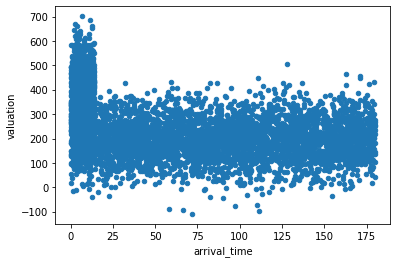

In [9]:
import numpy as np
np.random.seed(0)
pd.concat([generateCustomers() for i in range(20)])\
    .plot(x='arrival_time',y='valuation',kind='scatter')

In [10]:
data=[[170,50],[150,40],[13,95],[12,100]]
customers=pd.DataFrame(data,columns=['arrival_time','valuation'])

print('Constant policy with 2 seats p=50 \t:',simulateConstant(customers,2,50))
print('Constant policy with 2 seats p=100 \t:',simulateConstant(customers,2,100))
print('Dynamic policy with 3 seats p1=40, p2=95 \t:',simulateDynamic(customers,3,40,95))
print('Dynamic policy with 2 seats p1=40, p2=95 \t:',simulateDynamic(customers,2,40,95))
print('Dynamic policy with 1 seats p1=50, p2=100 \t:',simulateDynamic(customers,1,50,100))
print('Rationing policy with 3 seats p1=40, p2=100, l=1 \t:',\
        simulateRationing(customers,3,40,100,1))
print('Rationing policy with 2 seats p1=40, p2=100, l=1 \t:',\
        simulateRationing(customers,2,40,100,1))
print('Rationing policy with 1 seats p1=40, p2=95, l=1 \t:',\
        simulateRationing(customers,1,40,95,1))

Constant policy with 2 seats p=50 	: 100
Constant policy with 2 seats p=100 	: 100
Dynamic policy with 3 seats p1=40, p2=95 	: 175
Dynamic policy with 2 seats p1=40, p2=95 	: 80
Dynamic policy with 1 seats p1=50, p2=100 	: 50
Rationing policy with 3 seats p1=40, p2=100, l=1 	: 180
Rationing policy with 2 seats p1=40, p2=100, l=1 	: 140
Rationing policy with 1 seats p1=40, p2=95, l=1 	: 95
